In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
files = {
    "News": "Newsletter_Interaction_Data.csv",
    "Bugs": "Product_Bug_Task_Data.csv",
    "Regions": "RegionAndVertical_Data.csv",
    "Status": "StatusAndLevel_Data.csv",
    "CSAT": "CSAT_Survey_Data.csv",
    "Age": "Customer_Age_Data.csv",
    "MRR": "Customer_MRR_Data.csv",
    "Rev": "Customer_Revenue_Data.csv",
    "Tickets": "Help_Ticket_Data.csv",
}

In [3]:
dfs = {}
for k, v in files.items():
    try:
        dfs[k] = pd.read_csv(f"archive/{v}")
    except:
        print(f"couldn't load {v}")

In [4]:
# There is a mismatch between data files. In Customer Age Data, other than all the files Customer ID is written as "CRM ID"

dfs["Age"].rename(columns={"CRM ID": "Customer ID"}, inplace=True)

In [5]:
def fix_currency(x):
    x = str(x)
    return float(x.replace("$", "").replace(",", ""))
    


dfs["MRR"]["MRR"] = dfs["MRR"]["MRR"].apply(fix_currency)
dfs["Rev"]["Total Revenue"] = dfs["Rev"]["Total Revenue"].apply(fix_currency)

In [6]:
print(dfs["MRR"]["MRR"])
print(dfs["Rev"]["Total Revenue"])

0        8212.0
1        2026.0
2        2100.0
3        2900.0
4        1898.0
         ...   
1375      663.0
1376     6500.0
1377    10000.0
1378     1521.0
1379     2135.0
Name: MRR, Length: 1380, dtype: float64
0        732199.0
1             0.0
2        375135.0
3             0.0
4        116732.0
          ...    
896       16527.0
897           0.0
898      567026.0
899    15967518.0
900       30478.0
Name: Total Revenue, Length: 901, dtype: float64


In [7]:
# lets check what we got
for name, df in dfs.items():
    print(f"{name}: {df['Customer ID'].nunique()} customers, {len(df)} rows")

News: 251 customers, 251 rows
Bugs: 640 customers, 1989 rows
Regions: 2651 customers, 2655 rows
Status: 2651 customers, 2655 rows
CSAT: 640 customers, 1989 rows
Age: 2651 customers, 2651 rows
MRR: 1380 customers, 1380 rows
Rev: 901 customers, 901 rows
Tickets: 1367 customers, 1367 rows


All of them includes different number of customers. And also when I examine the data I can see there is multiple number of same customers (by looking at the prints and see rows - customers > 0 in most and also looking at the data files itself). 

Now we must aggregate the data 


In [8]:
print(dfs["CSAT"].columns)

Index(['Customer ID', 'Year', 'Quarter', 'Survey Date', 'Response Date',
       'How likely are you to recommend insider to a friend or colleague ',
       'How would you rate the value you gain from our company',
       'How frequently are you using our platform',
       'Please rate the overall quality of our products',
       'Please rate the usability of the panel',
       'Please rate your understanding of our reporting capabilities in the panel'],
      dtype='object')


In [9]:
csat_cols = [
    "How likely are you to recommend insider to a friend or colleague ",
    "How would you rate the value you gain from our company",
    "Please rate the overall quality of our products",
    "Please rate the usability of the panel",
    'How frequently are you using our platform',
    'Please rate your understanding of our reporting capabilities in the panel'
]

In [10]:
# Create mappings for categorical variables
frequency_mapping = {
    'Once a Day': 4,
    'Once a Week': 3, 
    'Once a Month': 2,
    '': 0  
}

understanding_mapping = {
    'I am able to report everything easily': 5,
    'I can pull all the numbers, but don\'t understand them': 4,
    'I tried but could not find everything I need': 3,
    'I need someone from Insider team to provide me the report from the panel': 2,
    'I don\'t use it often': 1,
    '': 0  
}

dfs["CSAT"]['How frequently are you using our platform'] = dfs["CSAT"]['How frequently are you using our platform'].map(frequency_mapping)
dfs["CSAT"]['Please rate your understanding of our reporting capabilities in the panel'] = dfs["CSAT"]['Please rate your understanding of our reporting capabilities in the panel'].map(understanding_mapping)

In [11]:
dfs["Bugs"] = (
    dfs["Bugs"].groupby("Customer ID", as_index=False)["Product Bug Task Count"].sum()
)
dfs["CSAT"] = dfs["CSAT"].groupby("Customer ID", as_index=False).mean(csat_cols)

# mode for categorical stuff (found it on stackoverflow)
mode_agg = lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
dfs["Regions"] = dfs["Regions"].groupby("Customer ID").agg(mode_agg).reset_index()
dfs["Status"] = dfs["Status"].groupby("Customer ID").agg(mode_agg).reset_index()

In [12]:
df = dfs["Age"]

# add the rest one by one
for k, v in dfs.items():
    if k != "Age":  # skip the first one
        df = df.merge(v, on="Customer ID", how="left")

In [13]:
print(f"{len(df)} row and {df['Customer ID'].nunique()} customers")

2651 row and 2651 customers


In [14]:
# detecting the missing data
miss = df.isnull().sum()
miss_percent = (miss / len(df)) * 100

miss_df = pd.DataFrame({"Missing": miss, "Percent": miss_percent})

print(miss_df)

                                                    Missing    Percent
Customer ID                                               0   0.000000
Customer Age (Months)                                     0   0.000000
Company Newsletter Interaction Count                   2400  90.531875
Product Bug Task Count                                 2013  75.933610
Region                                                    1   0.037722
Vertical                                                 66   2.489627
Subvertical                                             102   3.847605
Status                                                    0   0.000000
Customer Level                                            1   0.037722
Year                                                   2013  75.933610
Quarter                                                2013  75.933610
How likely are you to recommend insider to a fr...     2013  75.933610
How would you rate the value you gain from our ...     2013  75.933610
How fr

Let's fix the missing values with filling them with 0 or mode or median according to data type

In [15]:
df["Company Newsletter Interaction Count"] = df[
    "Company Newsletter Interaction Count"
].fillna(0)
df["Product Bug Task Count"] = df["Product Bug Task Count"].fillna(0)
df["MRR"] = df["MRR"].fillna(0)
df["Total Revenue"] = df["Total Revenue"].fillna(0)
df["Help Ticket Count"] = df["Help Ticket Count"].fillna(0)
df["Help Ticket Lead Time (hours)"] = df["Help Ticket Lead Time (hours)"].fillna(0)

In [16]:
nums = df.select_dtypes(include=[np.number]).columns
for col in nums:
    df[col] = df[col].fillna(df[col].median())

In [17]:
cats = ["Region", "Vertical", "Subvertical", "Customer Level"]
for col in cats:
    df[col] = df[col].fillna(df[col].mode()[0])

In [18]:
df.isnull().sum()

Customer ID                                                                  0
Customer Age (Months)                                                        0
Company Newsletter Interaction Count                                         0
Product Bug Task Count                                                       0
Region                                                                       0
Vertical                                                                     0
Subvertical                                                                  0
Status                                                                       0
Customer Level                                                               0
Year                                                                         0
Quarter                                                                      0
How likely are you to recommend insider to a friend or colleague             0
How would you rate the value you gain from our compa

Dataset is successfully cleaned

In [19]:
df.describe()

,Customer Age (Months),Company Newsletter Interaction Count,Product Bug Task Count,Year,Quarter,How likely are you to recommend insider to a friend or colleague,How would you rate the value you gain from our company,How frequently are you using our platform,Please rate the overall quality of our products,Please rate the usability of the panel,Please rate your understanding of our reporting capabilities in the panel,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours)
count,2651.000000,2651.000000,2651.000000,2651.0,2651.000000,2651.000000,2651.000000,2651.000000,2651.000000,2651.000000,2651.000000,2651.000000,2.651000e+03,2651.000000,2651.000000
mean,20.077707,0.417955,105.884949,2022.0,2.029218,8.322515,4.260498,3.326566,4.018085,4.001992,3.198973,1970.419087,4.279350e+06,8.971332,405.460581
std,16.427542,2.096620,236.127209,0.0,0.289876,0.646043,0.311563,0.284820,0.333464,0.344418,0.572355,4249.488494,7.128351e+07,20.174052,622.774163
min,1.000000,0.000000,0.000000,2022.0,1.000000,1.666667,1.666667,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,7.000000,0.000000,0.000000,2022.0,2.000000,8.354167,4.267857,3.333333,4.000000,4.000000,3.183333,0.000000,0.000000e+00,0.000000,0.000000
50%,15.000000,0.000000,0.000000,2022.0,2.000000,8.354167,4.267857,3.333333,4.000000,4.000000,3.183333,57.000000,0.000000e+00,1.000000,123.000000
75%,27.000000,0.000000,0.000000,2022.0,2.000000,8.354167,4.267857,3.333333,4.000000,4.000000,3.183333,2409.500000,1.325000e+03,9.000000,622.000000
max,72.000000,54.000000,1665.000000,2022.0,3.000000,10.000000,5.000000,4.000000,5.000000,5.000000,5.000000,62732.000000,2.789805e+09,443.000000,11632.000000


In [20]:
df.dtypes

Customer ID                                                                   object
Customer Age (Months)                                                          int64
Company Newsletter Interaction Count                                         float64
Product Bug Task Count                                                       float64
Region                                                                        object
Vertical                                                                      object
Subvertical                                                                   object
Status                                                                        object
Customer Level                                                                object
Year                                                                         float64
Quarter                                                                      float64
How likely are you to recommend insider to a friend or colleague 

In [21]:
num_cols = [
    "Customer Age (Months)",
    "Company Newsletter Interaction Count",
    "Product Bug Task Count",
    "MRR",
    "Total Revenue",
    "Help Ticket Count",
    "Help Ticket Lead Time (hours)",
]
money_cols = [
    "MRR",
    "Total Revenue",
    "Help Ticket Count",
    "Help Ticket Lead Time (hours)",
]

<Figure size 1200x800 with 0 Axes>

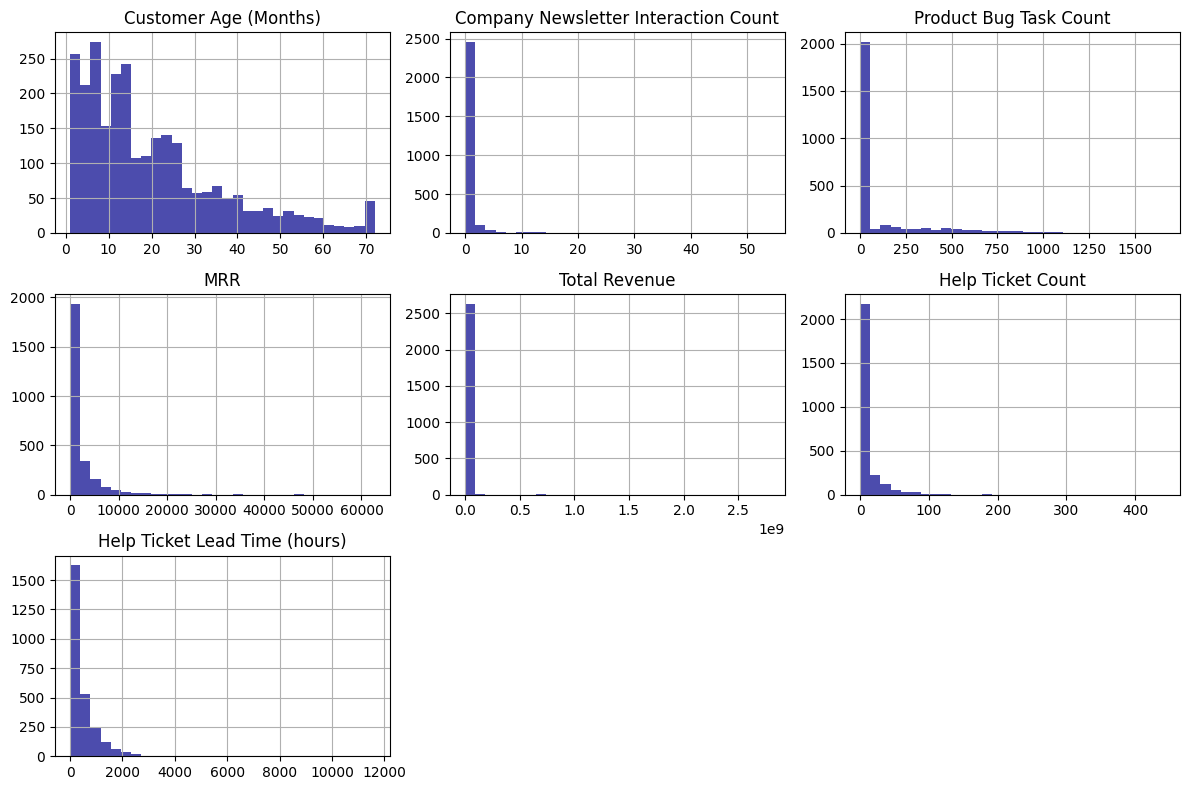

In [22]:
plt.figure(figsize=(12, 8))
df[num_cols].hist(bins=30, figsize=(12, 8), layout=(3, 3), color="darkblue", alpha=0.7)
plt.tight_layout()
plt.title("Numerical Columns Distribution")
plt.show()

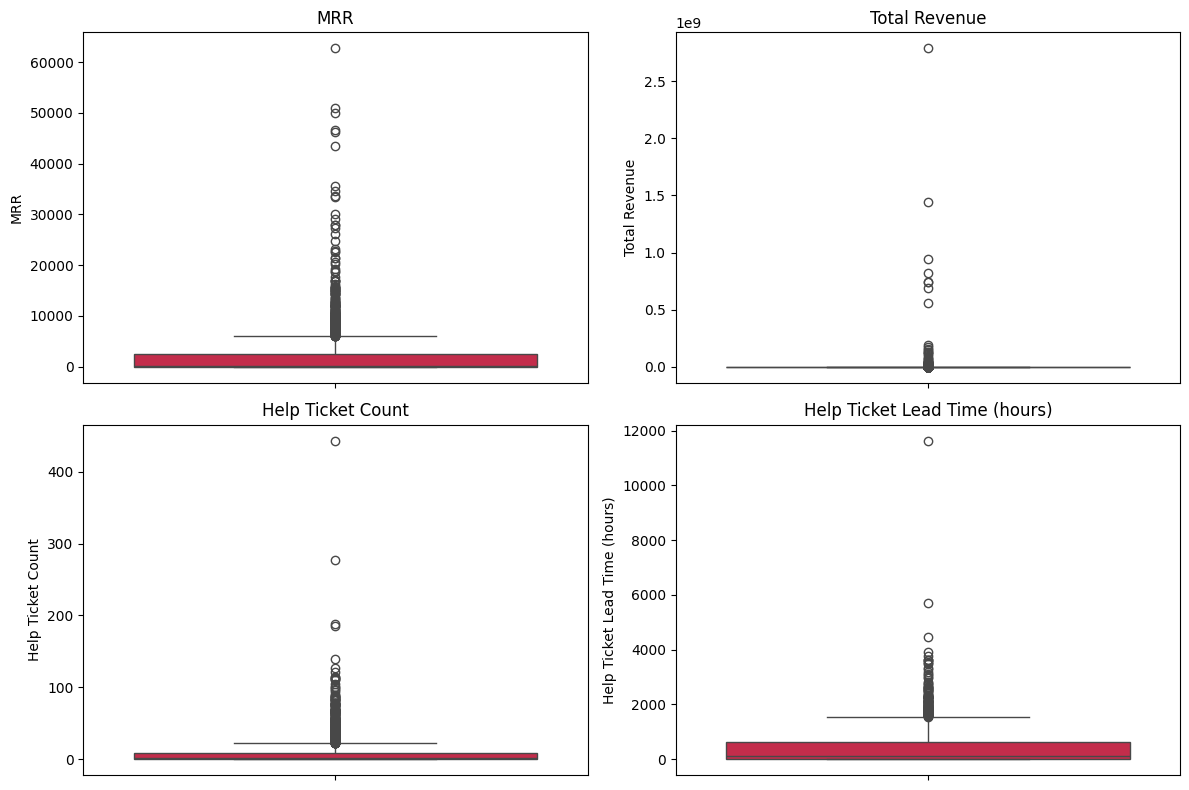

In [23]:
fig = plt.figure(figsize=(12, 8))
for i, c in enumerate(money_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[c], color="crimson")
    plt.title(f"{c}")

plt.tight_layout()
plt.show()

As you can see there is some outliers in the dataset that can be misleading to us. We can use some threshold technique for the solution.

In [24]:
# We will find outlier caps at 99% 
caps = {}

for c in money_cols:
    q99 = df[c].quantile(0.99)
    caps[c] = q99
    print(f"{c} 99% cap: {q99}")

MRR 99% cap: 18200.0
Total Revenue 99% cap: 31837480.5
Help Ticket Count 99% cap: 84.5
Help Ticket Lead Time (hours) 99% cap: 2584.0


In [25]:
for c, cap in caps.items():
    df[c] = df[c].apply(lambda x: min(x, cap))

In [26]:
df[money_cols].describe()

,MRR,Total Revenue,Help Ticket Count,Help Ticket Lead Time (hours)
count,2651.000000,2.651000e+03,2651.000000,2651.000000
mean,1839.033949,6.491012e+05,8.533195,395.161826
std,3275.125489,3.746402e+06,16.297205,550.147349
min,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000
50%,57.000000,0.000000e+00,1.000000,123.000000
75%,2409.500000,1.325000e+03,9.000000,622.000000
max,18200.000000,3.183748e+07,84.500000,2584.000000


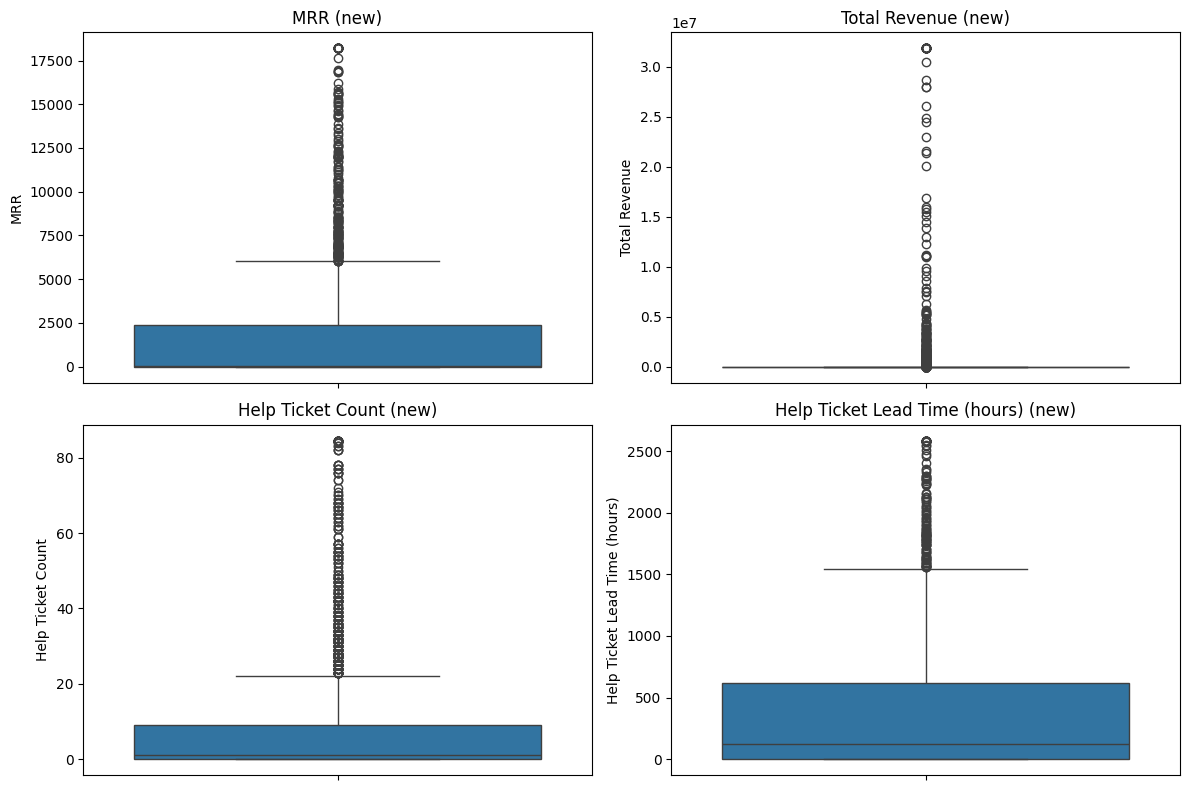

In [27]:
fig = plt.figure(figsize=(12, 8))
for i, c in enumerate(money_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[c])
    plt.title(f"{c} (new)")

plt.tight_layout()
plt.show()

Now I will look at most interesting columns for finding correlation

In [28]:
corr = df[
    [
        "MRR",
        "Total Revenue",
        "Help Ticket Count",
        "Help Ticket Lead Time (hours)",
        "How likely are you to recommend insider to a friend or colleague ",
        "How would you rate the value you gain from our company",
    ]
].corr()

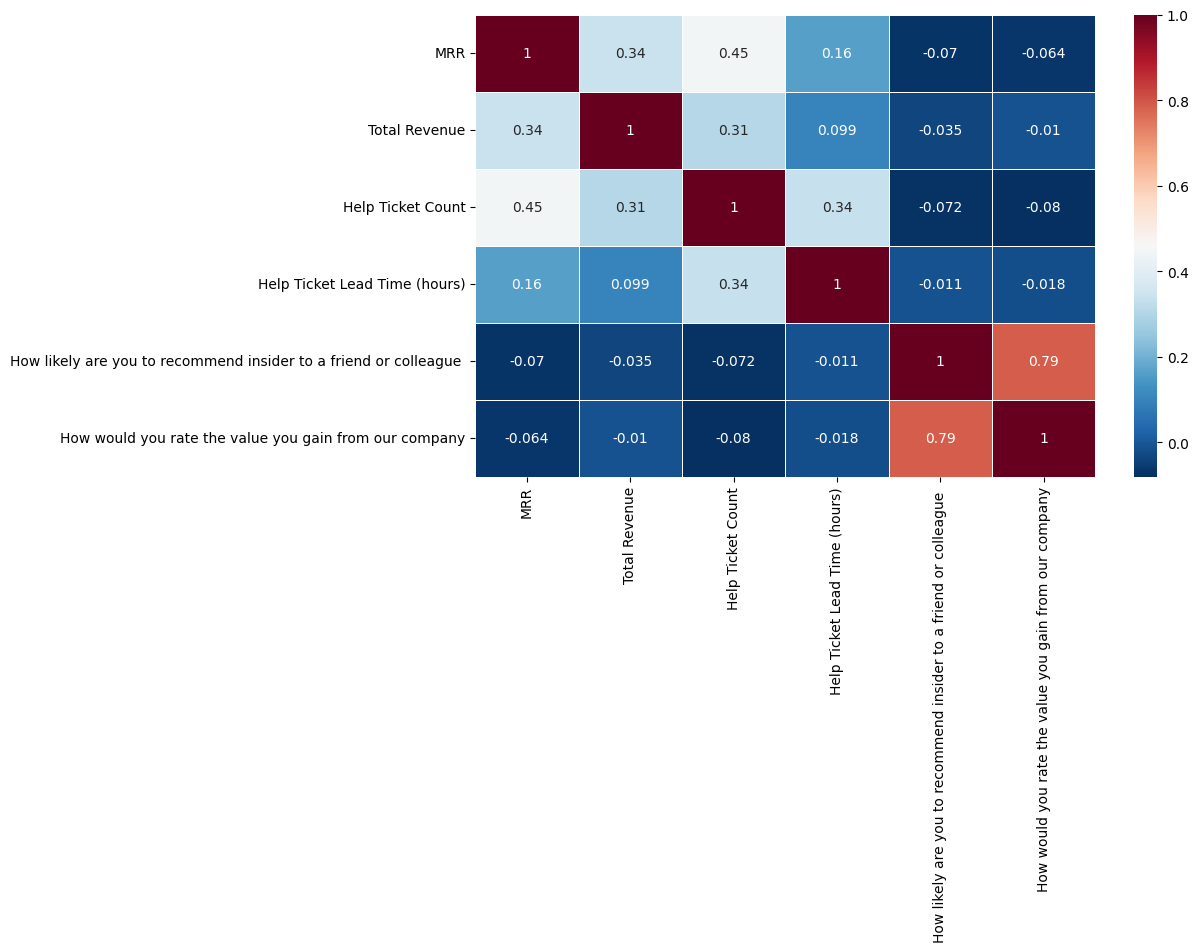

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="RdBu_r", linewidths=0.5)
plt.show()

When we look at the heatmap we can see there is a good amount of correlation between MRR and Help Ticket Count also stronger correlation between value gained from company and reccomendation

In [30]:
#For better analysis I will filter churned customers and active customers
active_df = df[df["Status"] != "Churn"]
churn_df = df[df["Status"] == "Churn"]

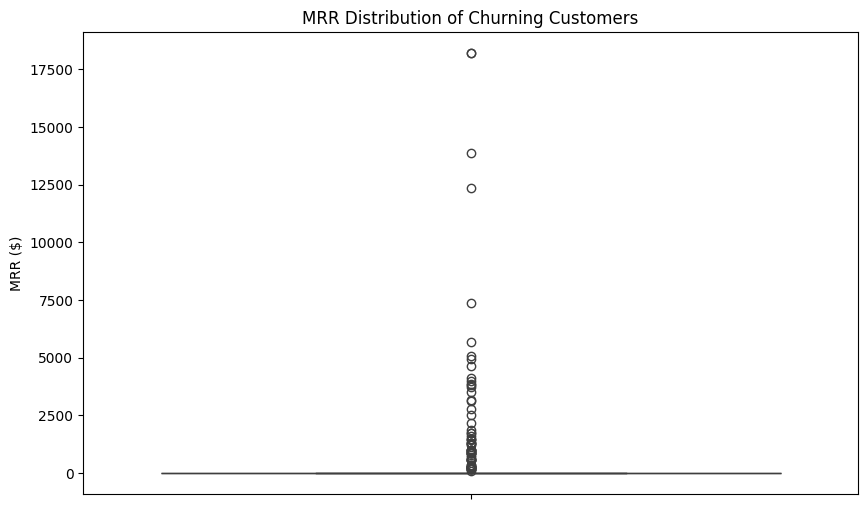

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=churn_df["MRR"])
plt.title("MRR Distribution of Churning Customers")
plt.ylabel("MRR ($)")
plt.show()

Big part of churning customers have lower MRR but also some of them have high MRR  

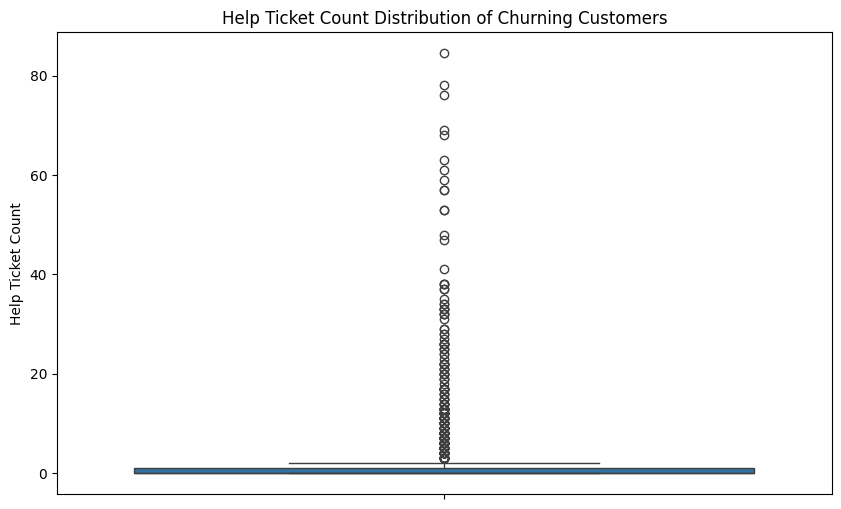

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=churn_df["Help Ticket Count"])
plt.title("Help Ticket Count Distribution of Churning Customers")
plt.ylabel("Help Ticket Count")
plt.show()

Most churning customers have a low number of help tickets but there are also significant outliers

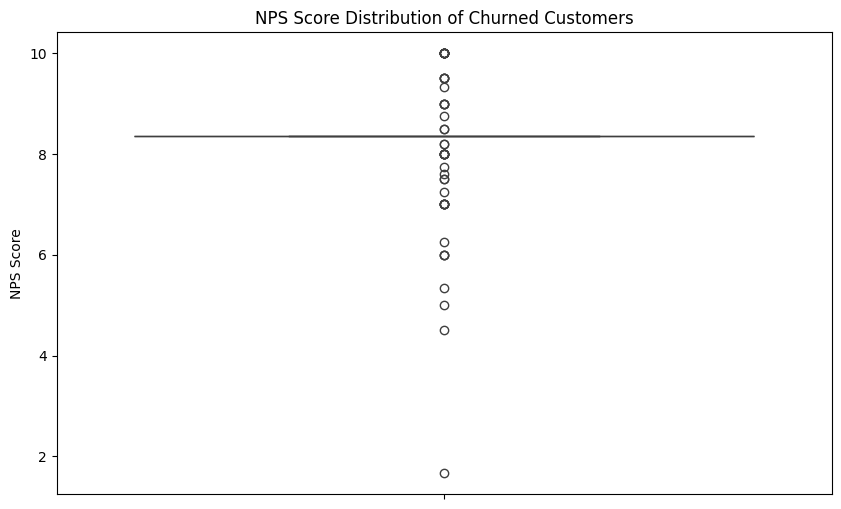

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=churn_df["How likely are you to recommend insider to a friend or colleague "])
plt.title("NPS Score Distribution of Churned Customers")
plt.ylabel("NPS Score")
plt.show()

Many churned customers have high NPS scores A few churned customers gave extremely low NPS scores. That is interesting.. Are there any product issues or maybe a pricing factor

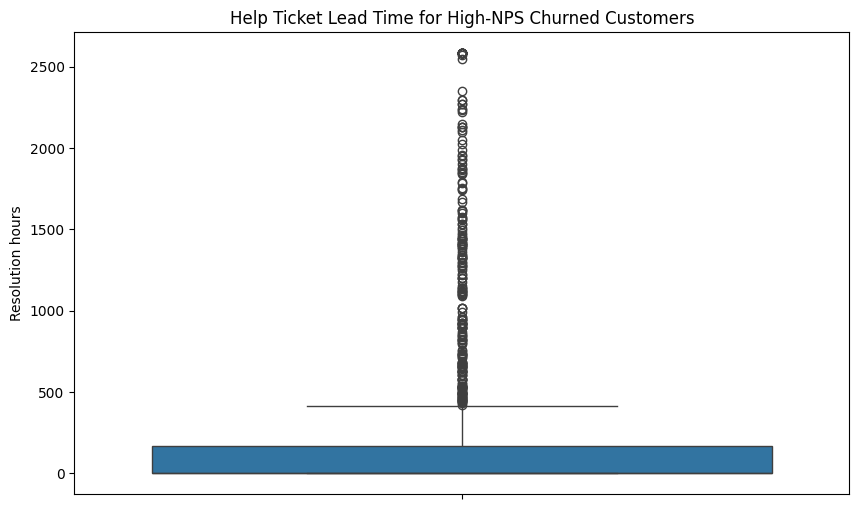

In [34]:
high_nps_churn = churn_df[churn_df["How likely are you to recommend insider to a friend or colleague "] >= 8]

plt.figure(figsize=(10, 6))
sns.boxplot(y=high_nps_churn["Help Ticket Lead Time (hours)"])
plt.title("Help Ticket Lead Time for High-NPS Churned Customers")
plt.ylabel("Resolution hours")
plt.show()


Many high-NPS churned customers experienced extremely long resolution times. This suggests that even satisfied customers might leave due to poor customer support response times.

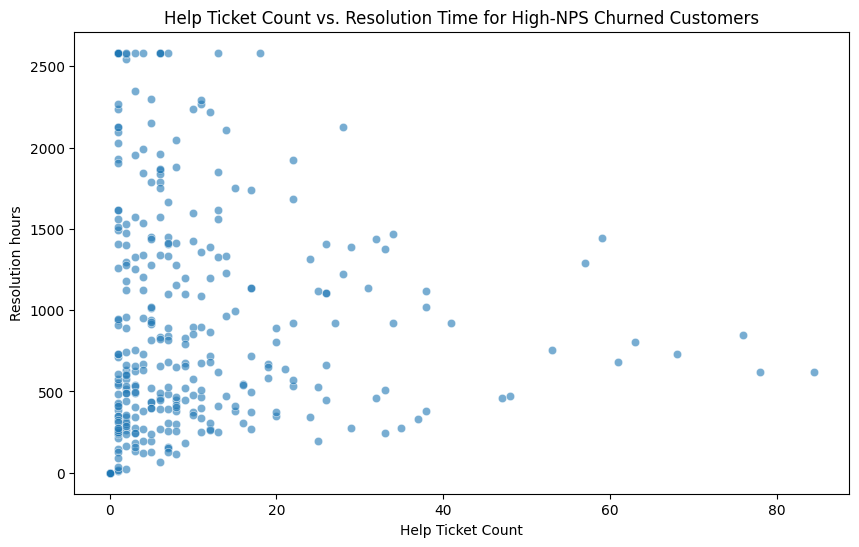

In [35]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=high_nps_churn["Help Ticket Count"], y=high_nps_churn["Help Ticket Lead Time (hours)"], alpha=0.6)
plt.title("Help Ticket Count vs. Resolution Time for High-NPS Churned Customers")
plt.xlabel("Help Ticket Count")
plt.ylabel("Resolution hours")
plt.show()

Many customers with low help ticket counts experienced very long resolution times and also we can see there is a incredible inconsistency. Now we must answer that if churned customers with long resolution times high-revenue customers or not.

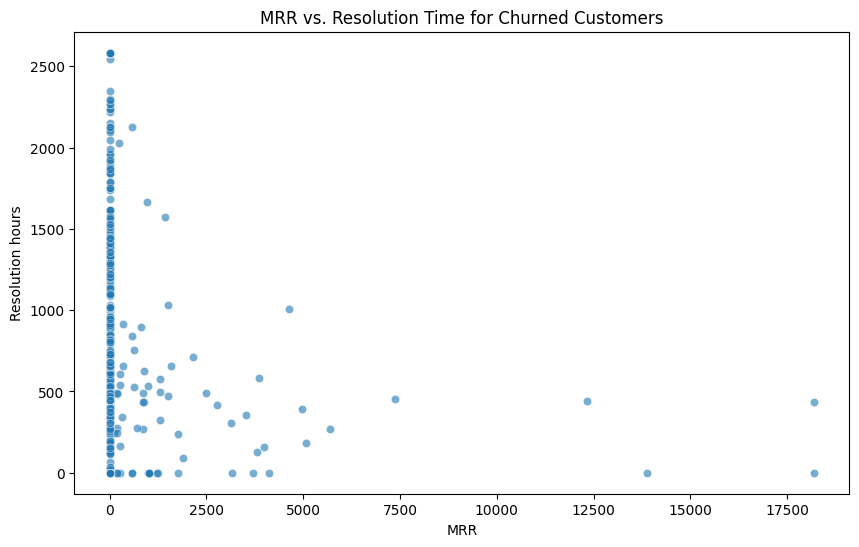

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=churn_df["MRR"], y=churn_df["Help Ticket Lead Time (hours)"], alpha=0.6)
plt.title("MRR vs. Resolution Time for Churned Customers")
plt.xlabel("MRR")
plt.ylabel("Resolution hours")
plt.show()

I think support process needs improvement but I do not think this is not the only reason for churn.

We must investigate more for High-MRR churn reasons. First we will analyze customer vertical (market) for churns

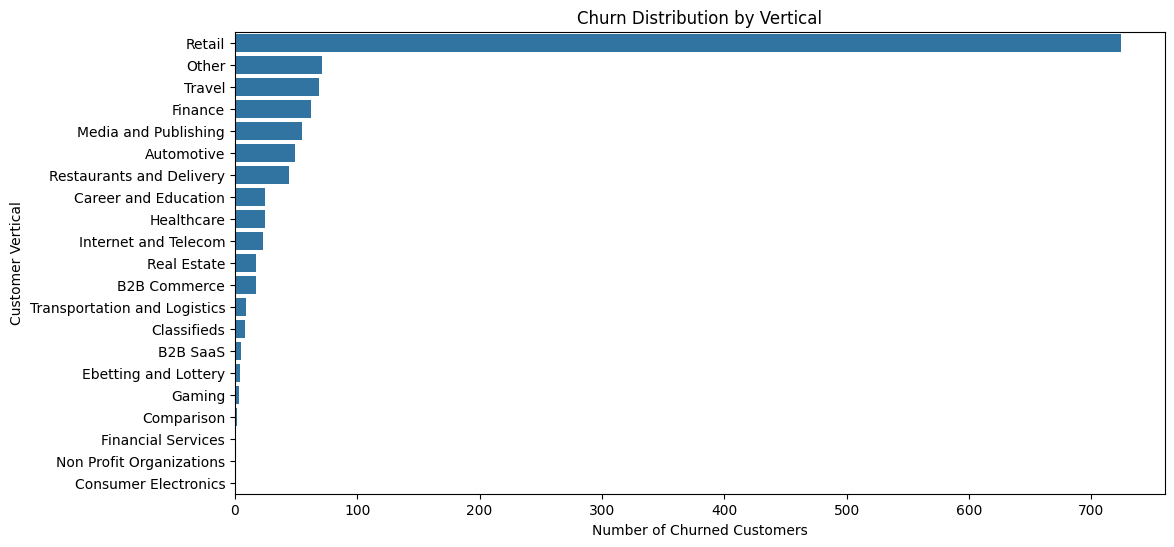

In [37]:
# Churn rate by customer vertical
plt.figure(figsize=(12, 6))
sns.countplot(y=churn_df["Vertical"], order=churn_df["Vertical"].value_counts().index)
plt.title("Churn Distribution by Vertical")
plt.xlabel("Number of Churned Customers")
plt.ylabel("Customer Vertical")
plt.show()


Interesting. Retail has the highest churn rate by far. Now we will look at how can we reduce churn in markets that have higher risk. First I want to look at the MRR distribution of every customer vertical

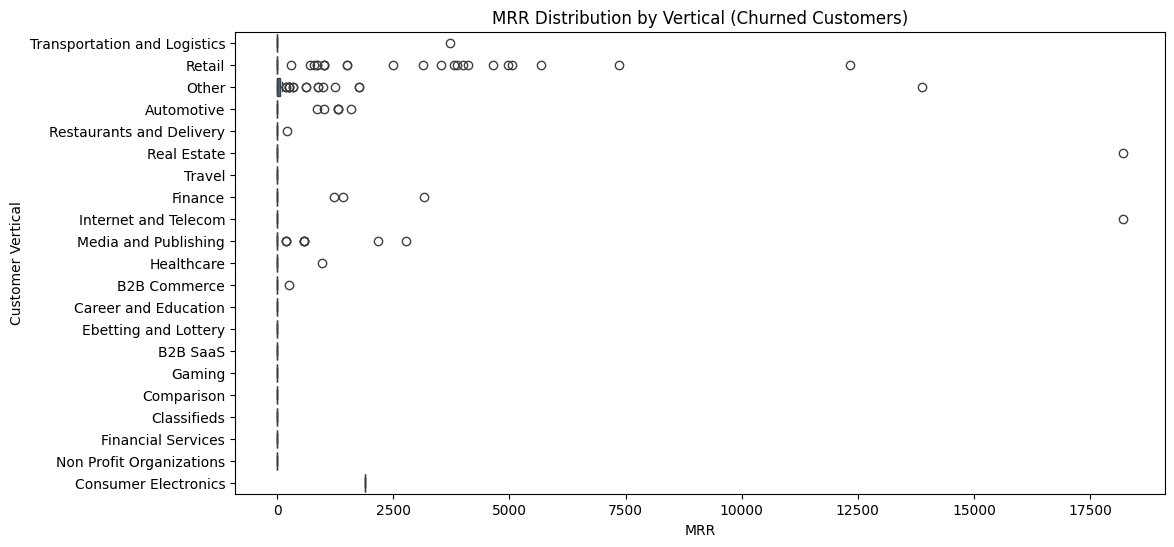

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=churn_df["Vertical"], x=churn_df["MRR"])
plt.title("MRR Distribution by Vertical (Churned Customers)")
plt.xlabel("MRR")
plt.ylabel("Customer Vertical")
plt.show()


Most of the churns are below the 2500 MRR. In retail there is some higher MRR customers too. Now I will analyze churn by customer level

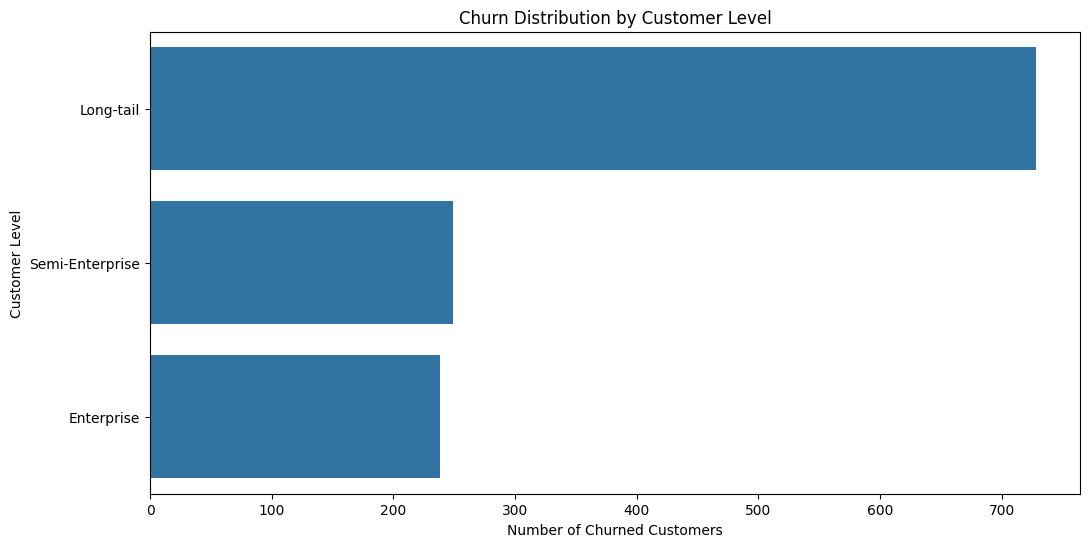

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(y=churn_df["Customer Level"], order=churn_df["Customer Level"].value_counts().index)
plt.title("Churn Distribution by Customer Level")
plt.xlabel("Number of Churned Customers")
plt.ylabel("Customer Level")
plt.show()


The majority of churned customers belong to the Long-Tail segment. This made me think maybe Long-Tail customers need beter retention strategies. But now, I will control if Long-Tail customers face longer support resolution hours

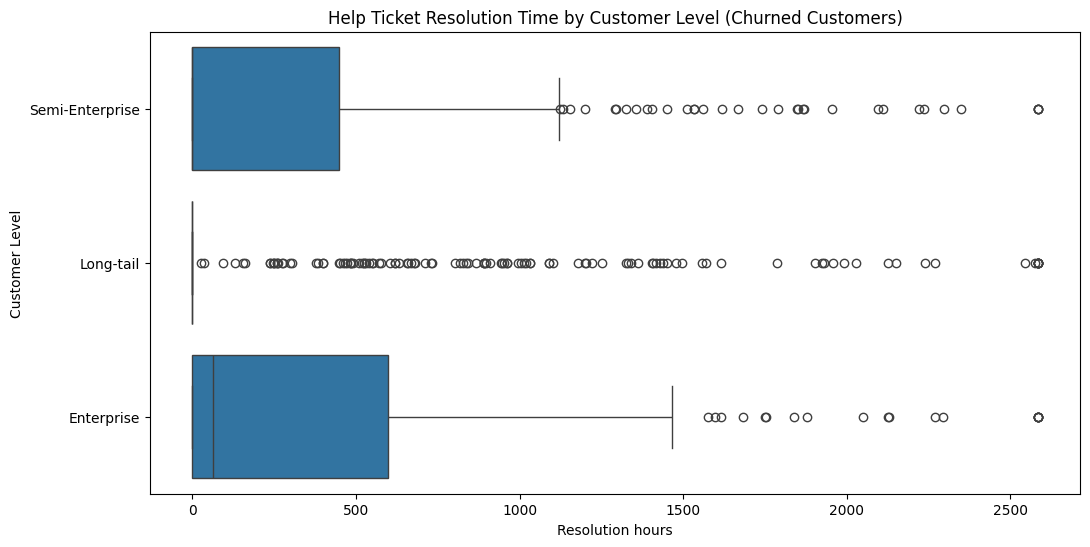

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=churn_df["Customer Level"], x=churn_df["Help Ticket Lead Time (hours)"])
plt.title("Help Ticket Resolution Time by Customer Level (Churned Customers)")
plt.xlabel("Resolution hours")
plt.ylabel("Customer Level")
plt.show()


This didn't work. But I think Enterprise level customers have more concentrated range below 500 hours or less. This made me think maybe Enterprise customers get more predictable support but the other face inconsistent service

Now I will examine the correlation between bug counts of churned customers and customer level

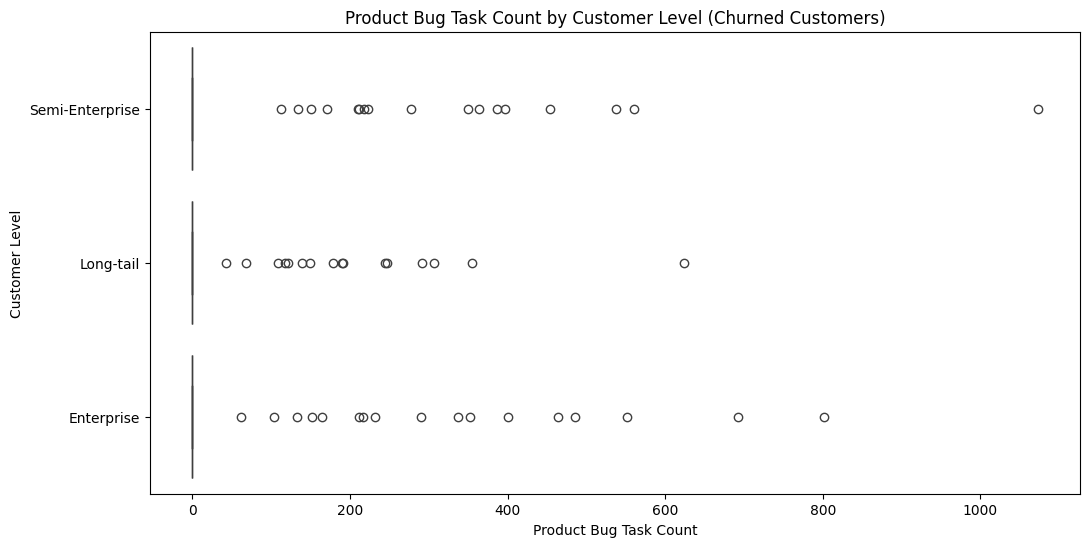

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=churn_df["Customer Level"], x=churn_df["Product Bug Task Count"])
plt.title("Product Bug Task Count by Customer Level (Churned Customers)")
plt.xlabel("Product Bug Task Count")
plt.ylabel("Customer Level")
plt.show()

Most churned customers reported zero or very few product bugs but some customers reported an extremely high number of bug issues before churning. And also Semi-Enterprise and Long-Tail customers show higher bug task counts compared to Enterprise.

I do not think product issues are churn driver as much as other issues I hope I will find out.

I want to use Supervised ML and investigate churn probability based on the data we have

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [43]:
categorical_cols = ["Customer Level", "Vertical", "Status"]
encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [44]:
# Convert Status column to binary Churn indicator (1=churned, 0=active customer)
df["Churn"] = (df["Status"] == 1).astype(int)

features = ["MRR", "Total Revenue", "Help Ticket Count", 
            "Help Ticket Lead Time (hours)", "Company Newsletter Interaction Count",
            "Product Bug Task Count", "Customer Level", "Vertical"]

X = df[features]
y = df["Churn"]

In [45]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# I will train 3 different models I selected
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

models = {"Logistic Regression": logreg, "Random Forest": rf, "XGBoost": xgb}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.9849
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       523
           1       0.00      0.00      0.00         8

    accuracy                           0.98       531
   macro avg       0.49      0.50      0.50       531
weighted avg       0.97      0.98      0.98       531

Random Forest Accuracy: 0.9812
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       523
           1       0.00      0.00      0.00         8

    accuracy                           0.98       531
   macro avg       0.49      0.50      0.50       531
weighted avg       0.97      0.98      0.98       531



c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

XGBoost Accuracy: 0.9849
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       523
           1       0.00      0.00      0.00         8

    accuracy                           0.98       531
   macro avg       0.49      0.50      0.50       531
weighted avg       0.97      0.98      0.98       531



c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Accuracy is high but recall & precision is 0. That means dataset is highly imbalanced. We must handle that situation. I searched through internet and find a technique named SMOTE that generates synthetic samples for minority class. I will use that

In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

and now I will retrain models

In [47]:
# Split our balanced dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size=0.2, random_state=42)

# Create three different machine learning models with settings to handle class imbalance
# Logistic Regression - a simple linear model for classification
logreg = LogisticRegression(class_weight="balanced", max_iter=1000)

# Random Forest - an ensemble of decision trees 
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

# XGBoost - a powerful gradient boosting algorithm
# We calculate the right weight based on the ratio of non-churned to churned customers
neg_pos_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb = XGBClassifier(scale_pos_weight=neg_pos_ratio, eval_metric="logloss")

# Store all models in a dictionary for easy iteration
models = {"Logistic Regression": logreg, "Random Forest": rf, "XGBoost": xgb}

# Train each model and evaluate its performance
for name, model in models.items():
    # Train the model on our training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Print accuracy score (percentage of correct predictions)
    print(f"🔹 {name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Print detailed classification metrics (precision, recall, f1-score)
    print(classification_report(y_test, y_pred))

🔹 Logistic Regression Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.96      0.54      0.69       549
           1       0.48      0.95      0.63       240

    accuracy                           0.67       789
   macro avg       0.72      0.75      0.66       789
weighted avg       0.81      0.67      0.68       789

🔹 Random Forest Accuracy: 0.8302
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       549
           1       0.67      0.88      0.76       240

    accuracy                           0.83       789
   macro avg       0.80      0.84      0.81       789
weighted avg       0.86      0.83      0.84       789

🔹 XGBoost Accuracy: 0.8352
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       549
           1       0.68      0.88      0.76       240

    accuracy                           0.84       789
   macro avg       0.81      

XGBoost > Random Forest > Logistic Regression. So I will use hyperparameter tuning for XGBoost to make it even better

In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Perform randomized search for parameters
xgb_tuned = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), eval_metric="logloss")
xgb_search = RandomizedSearchCV(xgb_tuned, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, random_state=42)
xgb_search.fit(X_train, y_train)

# Evaluate best model
best_xgb = xgb_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.82      0.87       549
           1       0.68      0.88      0.76       240

    accuracy                           0.83       789
   macro avg       0.81      0.85      0.82       789
weighted avg       0.86      0.83      0.84       789



Now we have a powerful ML model for churn prediction. I explored some technique named SHAP for explaining data. I will use it now

In [49]:
import shap
import matplotlib.pyplot as plt

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


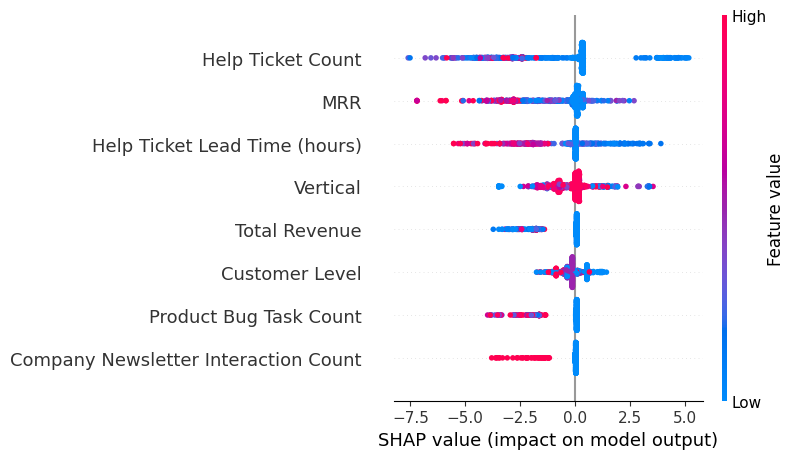

In [50]:
# Lets create SHAP explainer
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

# I will plot the overall feature importance
shap.summary_plot(shap_values, X_test)


Customers who create many help tickets and have unresolved issues are at the highest risk of churning

In [51]:
#for single customer
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

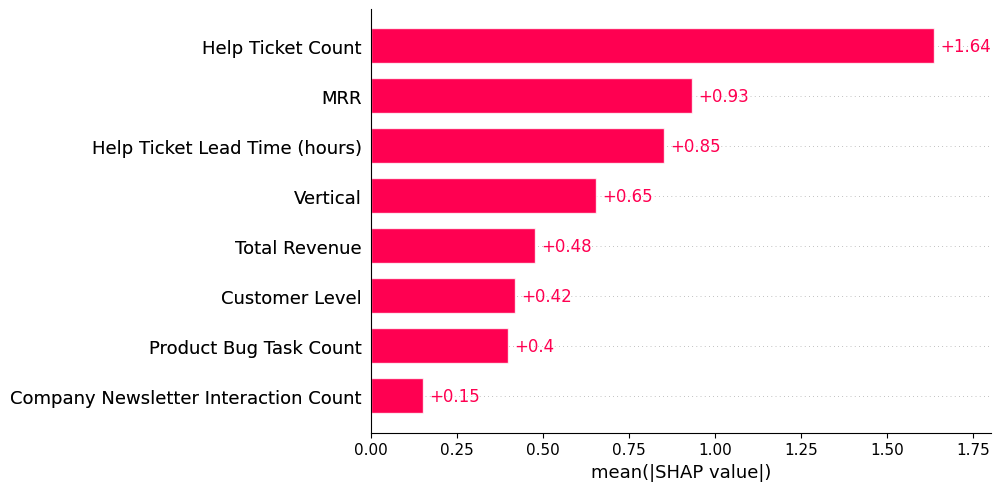

In [52]:
shap.plots.bar(shap_values)

Support-related issues are the biggest churn factors and also Low-MRR customers are much more likely to leave.

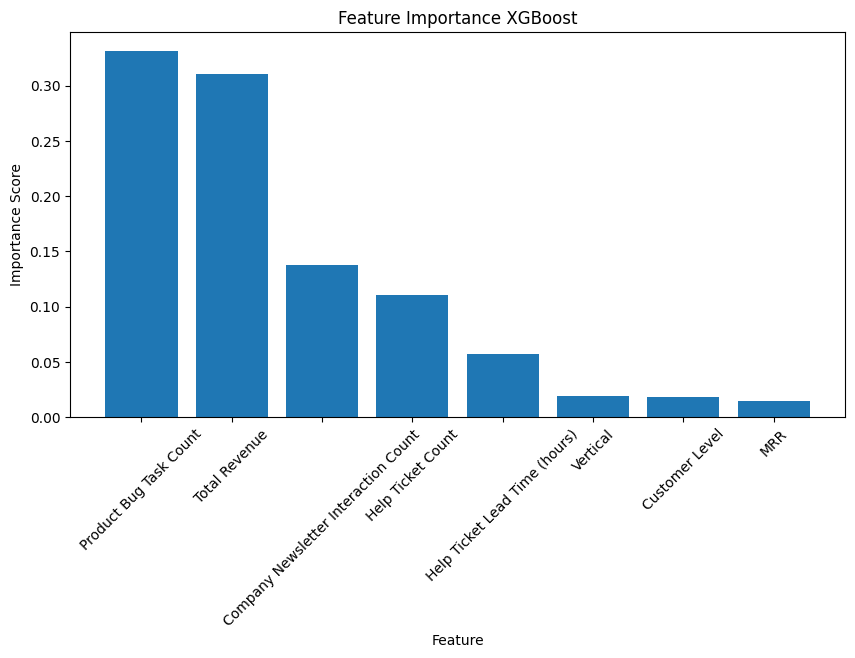

In [61]:
# Get feature importance from XGBoost
importances = best_xgb.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance XGBoost")
plt.show()
